# WACV -- CamVid

## 11 semantic classes

### NAS architectures based on MobileNet-v2 with 3 initial layers

In [1]:
%matplotlib inline

In [2]:
import glob
import sys
sys.path.append('../../src/')
from functools import partial

In [3]:
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from nn.encoders import mbv2
from nn.micro_decoders import TemplateDecoder as Decoder
from utils.helpers import prepare_img
from utils.model_zoo import load_url

In [5]:
class Segmenter(nn.Module):
    """Create Segmenter"""
    def __init__(self, encoder, decoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def _reset_clf(self, num_classes):
        self.decoder._reset_clf(num_classes)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [6]:
models_info = {
        'arch0': (
            [[[3, 0, 1], [4, 1, 1], [3, 1, 1]],
             [[0, 1, 0, 0, 1],
              [2, 1, 2, 1, 0],
              [3, 1, 1, 1, 0],
              [1, 1, 2, 0, 0],
              [3, 0, 2, 0, 0],
              [5, 3, 2, 1, 0],
              [0, 5, 0, 1, 0]]],
            'wacv_cv-166a860b.pth',
            'https://cloudstor.aarnet.edu.au/plus/s/K4sMKbFcDKNr53F/download'
        ),
        'arch1': (
            [[[1, 1, 0], [1, 3, 0], [3, 4, 0]],
             [[1, 1, 0, 0, 0],
              [0, 1, 1, 1, 1],
              [3, 1, 2, 3, 0],
              [3, 0, 2, 2, 0],
              [0, 1, 2, 0, 0],
              [2, 1, 1, 3, 0],
              [4, 0, 2, 2, 0]]],
            'wacv_cv-46afcbcb.pth',
            'https://cloudstor.aarnet.edu.au/plus/s/CfvQtC73RT0oMIQ/download'
        ),
}

In [7]:
# Configuration
AGG_SIZE = 64
REPEATS = 2
NUM_CLASSES = 11

In [8]:
cmap = cv2.imread('./../../src/utils/camvid_cmap.png').astype(np.uint8)[0][:, ::-1]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dec_fn = partial(Decoder,
                 num_classes=NUM_CLASSES,
                 agg_size=AGG_SIZE,
                 repeats=REPEATS)
img_dir = '../imgs/CamVid/'
imgs = glob.glob('{}*[0-9].png'.format(img_dir))

In [9]:
# Initialise models
models = dict()

for arch, (config, filename, url) in models_info.items():
    enc = mbv2(pretrained=False, return_layers=[1, 2])
    dec = dec_fn(config=config, inp_sizes=enc.out_sizes)
    segm = Segmenter(enc, dec).to(device).eval()
    segm.load_state_dict(load_url((arch + '_' + filename, url), map_location=device), strict=False)
    models[arch] = segm
    del enc

/home/vladimir/Documents/venvs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


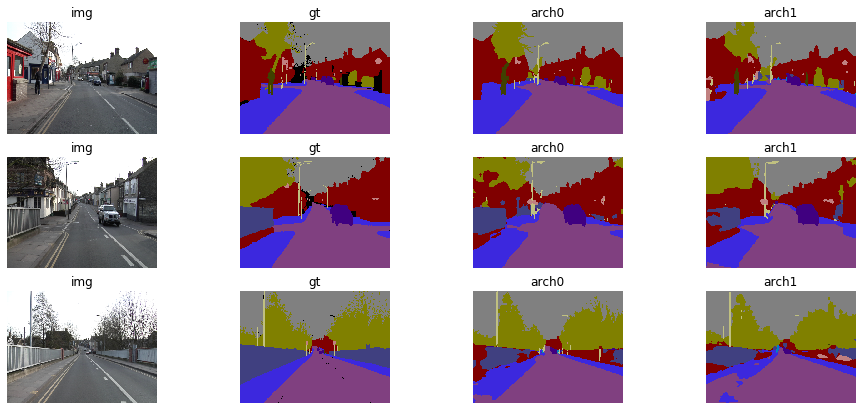

In [10]:
# Figure 11 from the paper
n_cols = len(models) + 2 # 1 - for image, 1 - for GT
n_rows = len(imgs)

plt.figure(figsize=(16, 7))
idx = 1

with torch.no_grad():
    for img_path in imgs:
        img = np.array(Image.open(img_path))
        msk = np.array(Image.open(img_path.replace('.png', 'gt.png')))
        orig_size = img.shape[:2][::-1]
        
        img_inp = torch.tensor(
            prepare_img(img).transpose(2, 0, 1)[None]).float().to(device)
        
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(img)
        plt.title('img')
        plt.axis('off')
        idx += 1
        
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(msk)
        plt.title('gt')
        plt.axis('off')
        idx += 1
        
        for mname, mnet in models.items():
            segm = mnet(img_inp)[0].squeeze().data.cpu().numpy().transpose((1, 2, 0))
            segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
            segm = cmap[segm.argmax(axis=2).astype(np.uint8)]
            
            plt.subplot(n_rows, n_cols, idx)
            plt.imshow(segm)
            plt.title(mname)
            plt.axis('off')
            idx += 1